# Lesson 18: Boosting

## **Project: X-AI Predictive Maintenance Model**
- **Source**: Matzka, Stephen (2020). Third International Conference on Artificial Intelligence for Industries (AI4I)
- **Date**: 01/09/20
- **Goal**: Create a basic prediction model and a feature explainer

In [3]:
import logging
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (
        train_test_split,
        cross_validate,
        cross_val_predict,
        GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    PowerTransformer,
    LabelEncoder,
    MinMaxScaler
)
from sklearn.ensemble import(
    GradientBoostingClassifier
)
from sklearn.metrics import(
    accuracy_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    DetCurveDisplay
)
from sklearn.inspection import permutation_importance
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [4]:
df_raw = pd.read_csv('../data/raw/ai4i2020.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [5]:
df_raw.sample(10, random_state=2025)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
6448,6449,H35862,H,300.7,310.2,1877,24.8,64,0,0,0,0,0,0
3544,3545,M18404,M,301.9,310.9,1483,37.0,35,0,0,0,0,0,0
3904,3905,H33318,H,302.2,311.1,1426,50.6,101,0,0,0,0,0,0
9739,9740,L56919,L,298.9,310.0,1515,42.9,170,0,0,0,0,0,0
8295,8296,L55475,L,298.9,310.4,1739,26.3,30,0,0,0,0,0,0
3600,3601,L50780,L,301.7,310.5,1523,34.7,181,0,0,0,0,0,0
1457,1458,L48637,L,299.0,310.3,1475,42.4,93,0,0,0,0,0,0
6938,6939,L54118,L,300.7,311.2,1452,44.4,33,0,0,0,0,0,0
984,985,L48164,L,296.3,307.1,1419,48.6,142,0,0,0,0,0,0
9586,9587,L56766,L,299.4,310.6,1348,54.5,22,0,0,0,0,0,0


|Name|Description|Type|Units|
|----|-----------|----|-----|
|UDI|Row ID|Int|None|
|Product ID|letters L, M, or H for low as product quality variants and a variant-specific SN.|Object|None|
|Type|letters L, M, or H for low as product quality variants|Object|None|
|Air temperature [K]|Temperature in Kelvin|Float|K|
|Process temperature [K]|Process temperature in Kelvin|Float|K|
|Rotational speed [rpm]|calculated from a power of 2860 W|Int|rpm|
|Torque [Nm]|torque values|Float|Nm|
|Tool wear [min]|minutes of tool wear to the used tool in the process|Int|min|
|Machine failure|label that indicates, whether the machine has failed in this particular datapoint.|Bool|None|
|TWF|tool wear failure|Bool|None|
|HDF|heat dissipation failure|Bool|None|
|PWF|power failure|Bool|None|
|OSF|overstrain failure|Bool|None|
|RNF|random failures|Bool|None|

### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [6]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.replace(" ", "_").str.replace("[", "").str.replace("]", "").str.lower()
df_baking = df_baking.drop(columns=["udi", "product_id"])
df_baking["type"] = df_baking["type"].astype('category')
df_baking["machine_failure"] = df_baking["machine_failure"].apply(lambda x:"yes" if x==1 else "no")
df_baking["machine_failure"] = df_baking["machine_failure"].astype('category')
df_baking = df_baking.drop(columns=["twf","hdf","pwf","osf","rnf"])
df = df_baking.copy()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   type                   10000 non-null  category
 1   air_temperature_k      10000 non-null  float64 
 2   process_temperature_k  10000 non-null  float64 
 3   rotational_speed_rpm   10000 non-null  int64   
 4   torque_nm              10000 non-null  float64 
 5   tool_wear_min          10000 non-null  int64   
 6   machine_failure        10000 non-null  category
dtypes: category(2), float64(3), int64(2)
memory usage: 410.5 KB


### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [7]:
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=2025,
    stratify=df['machine_failure'])
df_train, df_val = train_test_split(
    df_train,
    test_size=0.2,
    random_state=2025,
    stratify=df_train['machine_failure'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6400 entries, 7538 to 7522
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   type                   6400 non-null   category
 1   air_temperature_k      6400 non-null   float64 
 2   process_temperature_k  6400 non-null   float64 
 3   rotational_speed_rpm   6400 non-null   int64   
 4   torque_nm              6400 non-null   float64 
 5   tool_wear_min          6400 non-null   int64   
 6   machine_failure        6400 non-null   category
dtypes: category(2), float64(3), int64(2)
memory usage: 312.8 KB


In [8]:
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)
#vemos que la variable machine_failure esta desbalanceada

,count,mean,std,min,25%,50%,75%,max
air_temperature_k,6400.0,299.962672,1.999068,295.3,298.3,300.0,301.5,304.5
process_temperature_k,6400.0,309.978125,1.483554,305.7,308.8,310.0,311.0,313.8
rotational_speed_rpm,6400.0,1537.942656,177.971692,1183.0,1424.0,1504.0,1613.0,2886.0
torque_nm,6400.0,39.993016,9.888766,3.8,33.2,40.1,46.7,75.4
tool_wear_min,6400.0,108.214062,63.507630,0.0,54.0,108.0,162.0,253.0


,count,unique,top,freq
type,6400,3,L,3874
machine_failure,6400,2,no,6183


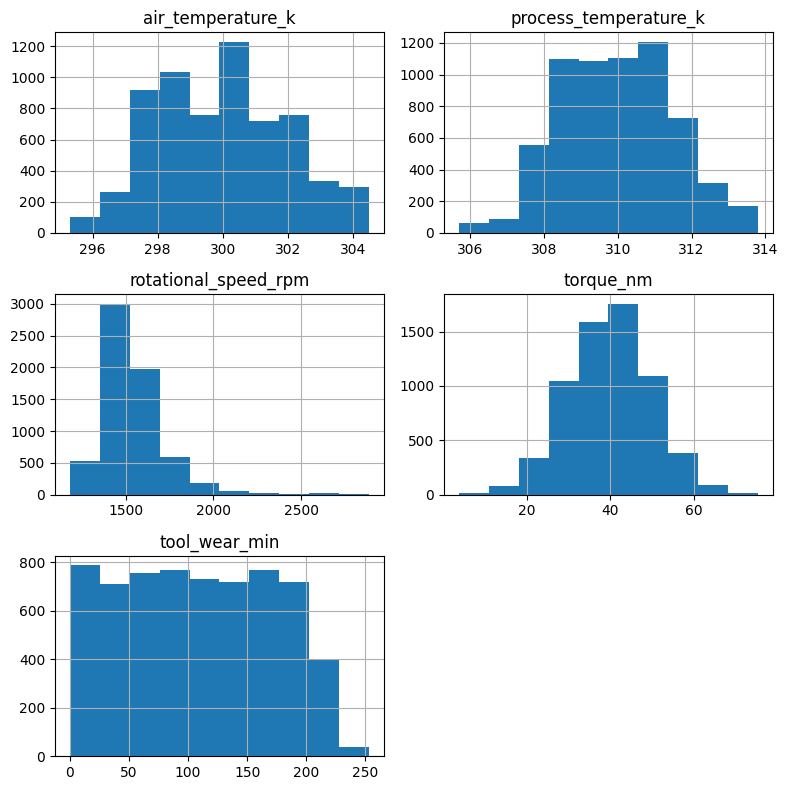

In [9]:
df_train.hist(figsize=(8,8))
plt.tight_layout()
plt.show()

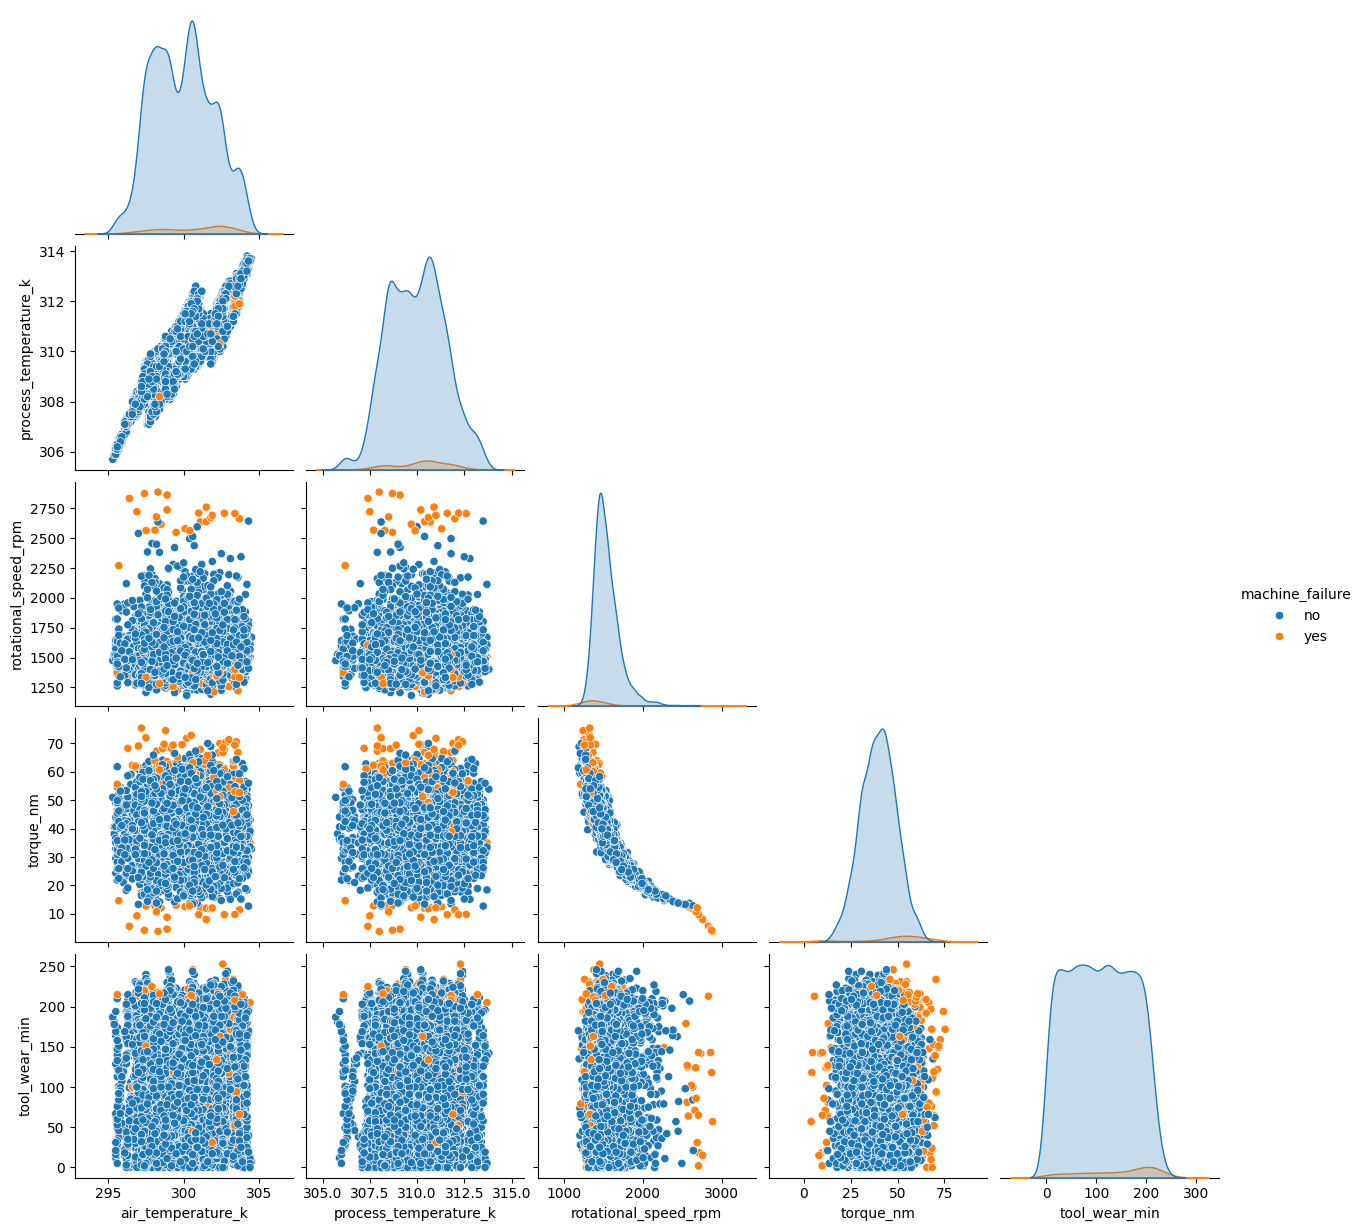

In [10]:
sns.pairplot(df_train, hue="machine_failure", corner=True)
plt.show()

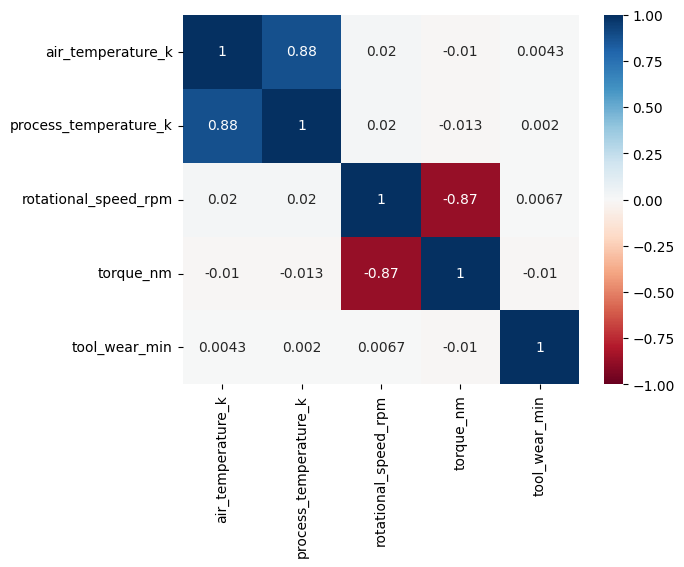

In [11]:
sns.heatmap(data=df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

### 4. Machine learning
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [12]:
X_train = df_train.drop(columns=['machine_failure'])
y_train = df_train['machine_failure'].copy()
X_val = df_val.drop(columns=['machine_failure'])
y_val = df_val['machine_failure'].copy()
X_test = df_test.drop(columns=['machine_failure'])
y_test = df_test['machine_failure'].copy()

In [ ]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)